<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/355_groups_comparison.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>


(groups_comparison_notebook)=
# Gruppi multipli

L'obiettivo di questo capitolo è di ampliare la discussione del capitolo {ref}`bayes_one_mean_notebook`, affrontando il confronto tra le medie di più di due gruppi indipendenti.  Per cominciare, carichiamo le librerie necessarie.

## Preparazione del notebook

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import pymc.sampling_jax
import xarray as xr
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

In questo tutorial useremo i dati relativi ai pinguini Palmer, che verranno letti da un file csv, escludendo le osservazini che presentano valori mancanti:

In [3]:
penguins = pd.read_csv("../data/penguins.csv")
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]
penguins.shape

(333, 8)

Otteniamo in questo modo un DataFrame con 333 righe e 8 colonne. Nella discussione seguente ci focalizzeremo sul peso `body_mass_g` in funzione della specie:

In [4]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Creiamo un grafico a violino per questi dati.

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


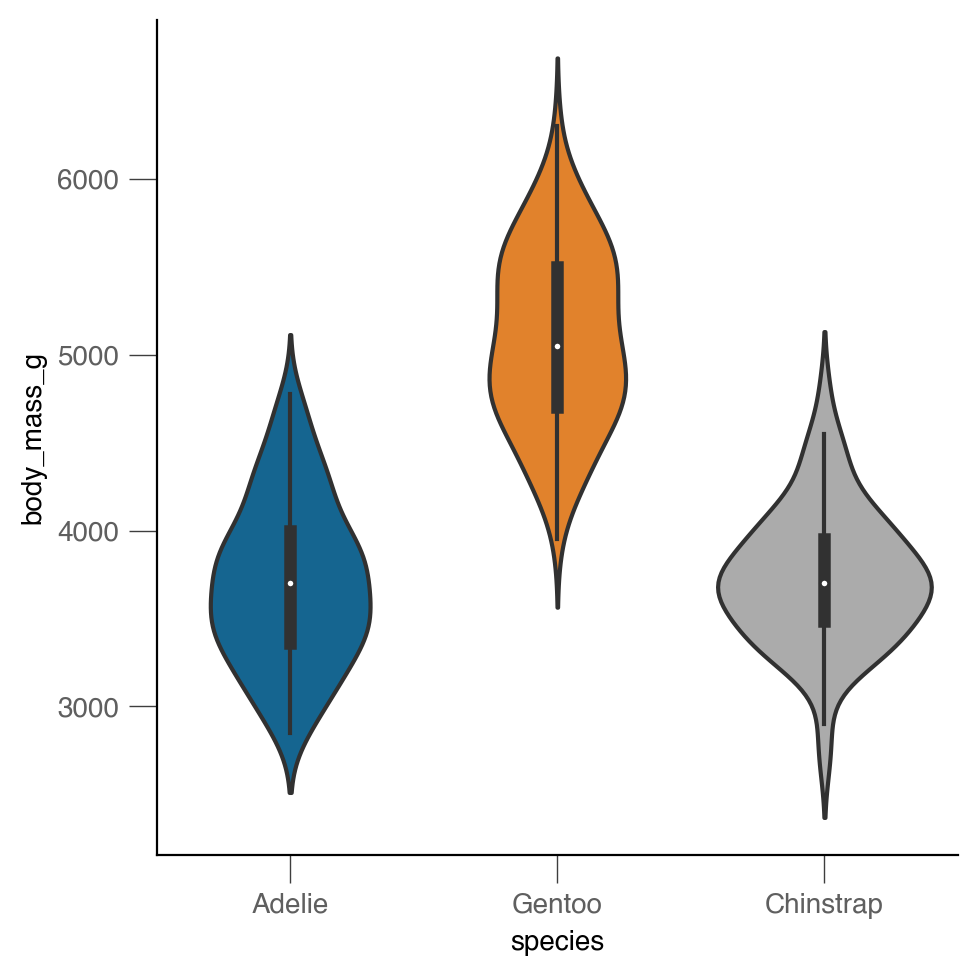

In [5]:
sns.catplot(kind="violin", data=penguins, x="species", y="body_mass_g")
plt.show()

La stima della media e della varianza ottenuta da un campione di osservazioni non è rappresentativa dell'intera popolazione di pinguini. Ci chiediamo, quindi, quale sia l'incertezza associata alla stima del peso per le tre specie di pinguini, considerando che abbiamo a disposizione solo un piccolo campione di osservazioni. Per fare ciò, dobbiamo definire un modello statistico che descriva la relazione tra i dati e i parametri. Nel nostro caso, descriviamo la distribuzione a posteriori dei parametri, tenendo conto dei dati, come segue:

$$
p(\mu, \sigma \mid y) \propto p(y \mid \mu, \sigma) p(\mu)p(\sigma),
$$

dove la verosimiglianza sarà una densità Normale, dipendente da due parametri: $\mu$ e $\sigma$. Inoltre, sarà necessario definire le distribuzioni a priori di questi due parametri.

Consideriamo qui due possibili soluzioni per quantificare l'incertezza della nostra stima mediante l'utilizzo dei metodi bayesiani.

## Usare MutableData per adattare lo stesso modello a diversi set di dati.

Il primo metodo richiede di ristrutturare i dati di interesse (`body_mass_g`) in un array multidimensionale che distingue tra le tre specie.

In [6]:
# Group the data by species and extract 'body_mass_g' values for each species
grouped = penguins.groupby('species')['body_mass_g']

# Create an empty list to store arrays for each species
observed_data = []

# Append each group's values as a separate NumPy array
for name, group in grouped:
    observed_data.append(np.array(group))

# Convert the list of arrays to a NumPy object array for multidimensional representation
observed_data = np.array(observed_data, dtype=object)
observed_data

array([array([3750., 3800., 3250., 3450., 3650., 3625., 4675., 3200., 3800.,
              4400., 3700., 3450., 4500., 3325., 4200., 3400., 3600., 3800.,
              3950., 3800., 3800., 3550., 3200., 3150., 3950., 3250., 3900.,
              3300., 3900., 3325., 4150., 3950., 3550., 3300., 4650., 3150.,
              3900., 3100., 4400., 3000., 4600., 3425., 3450., 4150., 3500.,
              4300., 3450., 4050., 2900., 3700., 3550., 3800., 2850., 3750.,
              3150., 4400., 3600., 4050., 2850., 3950., 3350., 4100., 3050.,
              4450., 3600., 3900., 3550., 4150., 3700., 4250., 3700., 3900.,
              3550., 4000., 3200., 4700., 3800., 4200., 3350., 3550., 3800.,
              3500., 3950., 3600., 3550., 4300., 3400., 4450., 3300., 4300.,
              3700., 4350., 2900., 4100., 3725., 4725., 3075., 4250., 2925.,
              3550., 3750., 3900., 3175., 4775., 3825., 4600., 3200., 4275.,
              3900., 4075., 2900., 3775., 3350., 3325., 3150., 3500., 3450.,

In [114]:
observed_data.shape

(3,)

Calcoliamo la media di tutte le osservazioni.

In [7]:
# Flatten the object array to get a single array containing all values
flattened_array = np.concatenate(observed_data)
# Compute the overall mean
overall_mean = np.mean(flattened_array)
print("Overall mean:", overall_mean)

Overall mean: 4207.057057057057


Utilizziamo un oggetto `MutableData` per immagazzinare i dati osservati. Nel modello, la verosimiglianza dei dati è descritta da una distribuzione gaussiana con media incognita `mu` e deviazione standard incognita `sigma`. Come prior per l'iperparametro `mu`, utilizziamo una distribuzione normale con una media di 4200 e una deviazione standard di 1000. Per l'iperparametro `sigma`, utilizziamo una distribuzione Half-Normal con una deviazione standard di 500.

In [8]:
with pm.Model() as model:
    data = pm.MutableData("data", observed_data[0])
    mu = pm.Normal("mu", 4200, 1000)
    sigma = pm.HalfNormal("sigma", 500)
    pm.Normal("y", mu=mu, sigma=sigma, observed=data)

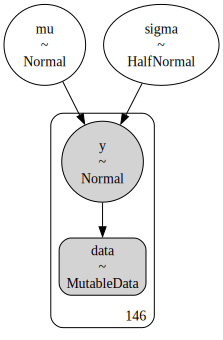

In [9]:
pm.model_to_graphviz(model)

Esaminiamo la distribuzione predittiva a priori.

In [10]:
with model:
    idata_prior = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [mu, sigma, y]


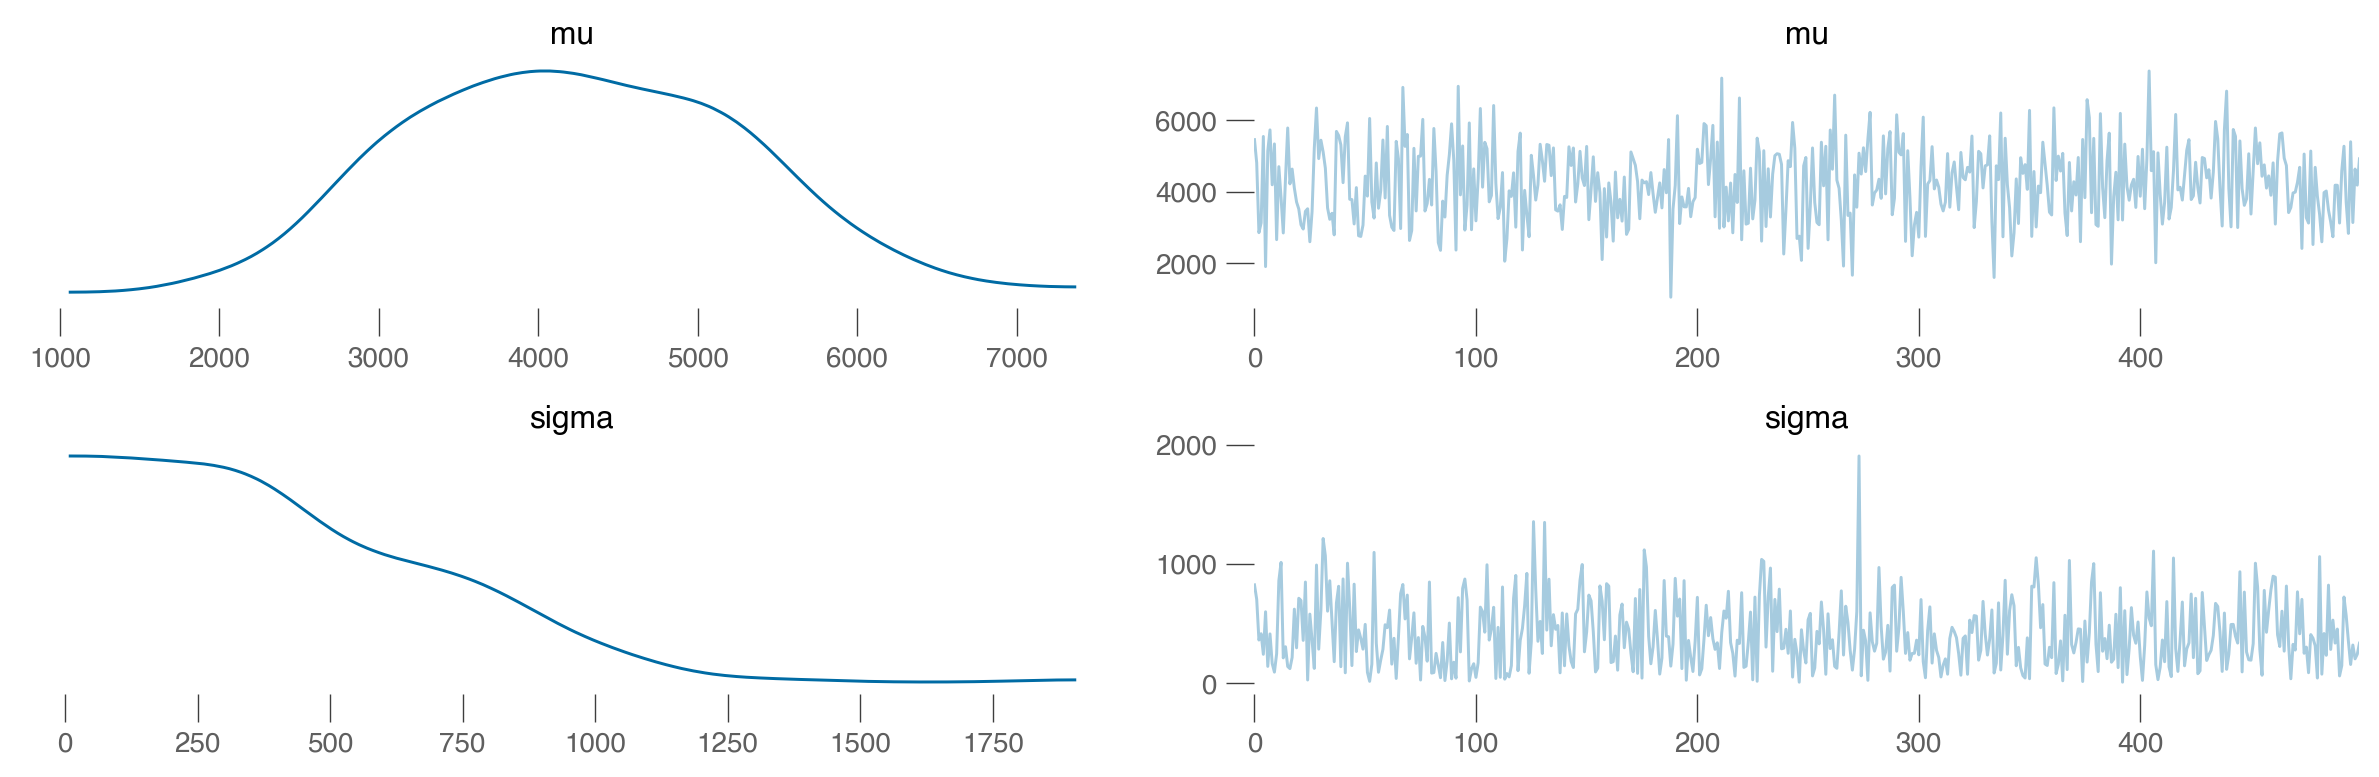

In [11]:
prior = idata_prior.prior
az.plot_trace(prior)
plt.tight_layout()
plt.show()

Eseguiamo il campionamento.

In [12]:
with model:
    idata_0 = pm.sampling_jax.sample_numpyro_nuts(idata_kwargs={"log_likelihood": True})

Compiling...
Compilation time =  0:00:01.593143
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 616.97it/s]


Sampling time =  0:00:03.590292
Transforming variables...
Transformation time =  0:00:00.024037
Computing Log Likelihood...
Log Likelihood time =  0:00:00.335050


Esaminiamo le distribuzioni a posteriori dei parametri del modello.

In [13]:
az.summary(idata_0, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3706.62,38.69,3634.14,3780.70,0.70,0.49,3107.46,2561.83,1.0
sigma,461.47,27.72,413.02,516.41,0.48,0.34,3387.18,2615.93,1.0


Ora applichiamo lo stesso modello sequenzialmenete a ciascuno dei tre data set.

In [14]:
# Generate one trace for each dataset
idatas = []
for data_vals in observed_data:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        idatas.append(pm.sampling_jax.sample_numpyro_nuts(random_seed=RANDOM_SEED))

Compiling...
Compilation time =  0:00:00.703471
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 644.61it/s]


Sampling time =  0:00:03.244212
Transforming variables...
Transformation time =  0:00:00.008519
Compiling...
Compilation time =  0:00:00.794442
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 722.77it/s]


Sampling time =  0:00:02.902049
Transforming variables...
Transformation time =  0:00:00.007198
Compiling...
Compilation time =  0:00:00.690917
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 570.73it/s]

Sampling time =  0:00:03.682106
Transforming variables...
Transformation time =  0:00:00.007854


Possiamo esaminare la soluzione separatamente per ciascun data set.

In [15]:
az.summary(idatas[0])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3706.787,39.254,3633.827,3781.532,0.723,0.511,2946.0,2266.0,1.0
sigma,461.581,27.323,411.267,512.173,0.454,0.323,3679.0,2712.0,1.0


In [16]:
az.summary(idatas[1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,3735.854,47.096,3652.264,3828.513,0.885,0.627,2818.0,2471.0,1.0
sigma,390.308,33.705,330.397,455.329,0.576,0.407,3397.0,2660.0,1.0


In [17]:
az.summary(idatas[2])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5091.940,45.850,5014.989,5186.715,0.816,0.577,3167.0,2254.0,1.0
sigma,504.854,32.255,447.687,568.648,0.529,0.377,3771.0,3010.0,1.0


## Un singolo modello e un singolo data set 

Nel modello seguente, conduciamo un'analisi in cui un singolo modello viene applicato simultaneamente a tutti e tre i set di dati. Questo è reso possibile attraverso l'indicizzazione dei dati, che ci permette di suddividere le osservazioni in base alle diverse specie di pinguini. La suddivisione dei dati secondo le varie specie viene effettuata mediante la creazione della variabile numerica `species_idx`, che assume i valori 0, 1 e 2 per le specie Adelie, Chinstrap e Gentoo, rispettivamente.

In [18]:
# Map species names to numerical indices
species_to_index = {'Adelie': 0, 'Chinstrap': 1, 'Gentoo': 2}
penguins['species_idx'] = penguins['species'].map(species_to_index)
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,species_idx
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,0
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,0
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007,0


In [19]:
n_obs = len(penguins)
n_obs

333

In [20]:
coords = {"species": [0, 1, 2], "obs_id": np.arange(n_obs)}

with pm.Model(coords=coords) as labeled_model:
    species = pm.ConstantData("species", penguins["species_idx"], dims="obs_id")
    body_mass = pm.ConstantData("body_mass", penguins["body_mass_g"], dims="obs_id")

    mu = pm.Normal("mu", mu=4000, sigma=1000, dims="species")
    sigma = pm.HalfCauchy("sigma", beta=1000, dims="species")

    # Use species as index
    y_obs = pm.Normal(
        "y_obs", mu=mu[species], sigma=sigma[species], observed=body_mass, dims="obs_id"
    )

In questo modello bayesiano gerarchico, l'obiettivo principale è inferire i parametri delle distribuzioni normali per la massa corporea (`body_mass_g`) in diverse specie di pinguini. A seguire, analizzeremo in dettaglio la struttura e la sintassi del modello.

```python
coords = {"species": [0, 1, 2], "obs_id": np.arange(n_obs)}
```

- `coords` definisce le coordinate per le dimensioni dei dati e dei parametri.
- `"species": [0, 1, 2]` indica che ci sono tre specie, ognuna identificata da un indice numerico.
- `"obs_id": np.arange(n_obs)` definisce un array di identificativi osservazionali che permette a PyMC di associare i punti dati osservati con le specie appropriate.

```python
with pm.Model(coords=coords) as labeled_model:
```

- Si dichiara un nuovo modello PyMC con le coordinate specificate. Tutte le operazioni PyMC successive saranno aggiunte a questo modello.

```python
species = pm.ConstantData("species", penguins["species_idx"], dims="obs_id")
body_mass = pm.ConstantData("body_mass", penguins["body_mass_g"], dims="obs_id")
```

- `species` è un dato costante che contiene l'indice della specie per ogni osservazione.
- `body_mass` rappresenta la massa corporea osservata per ogni pinguino nel dataset.
- `dims="obs_id"` specifica che questi array di dati devono essere associati alla dimensione delle coordinate `obs_id`, rendendo chiaro che ogni riga corrisponde a una singola osservazione.

```python
mu = pm.Normal("mu", mu=4000, sigma=1000, dims="species")
sigma = pm.HalfCauchy("sigma", beta=1000, dims="species")
```

- `mu` è la massa corporea media per ciascuna specie, modellata come una distribuzione normale con una media di 4000 e una deviazione standard di 1000.
- `sigma` è la deviazione standard della massa corporea per ciascuna specie, modellata come una distribuzione half-Cauchy con un parametro di scala (`beta`) di 1000.
- Sia `mu` che `sigma` sono vettori di lunghezza 3 (una voce per ogni specie).

```python
y_obs = pm.Normal("y_obs", mu=mu[species], sigma=sigma[species], observed=body_mass, dims="obs_id")
```

- `y_obs` rappresenta la verosimiglianza dei dati osservati dati i parametri.
- La media (`mu`) e la deviazione standard (`sigma`) per ogni osservazione sono indicizzate dalla specie di quella osservazione (`mu[species]`, `sigma[species]`). Ciò permette di avere osservazioni generate da distribuzioni normali con differenti parametri, a seconda della loro specie.
- `observed=body_mass` specifica che `y_obs` è una variabile osservata e i suoi valori osservati sono forniti da `body_mass`.

Generiamo la visualizzazione grafica della struttura del modello.

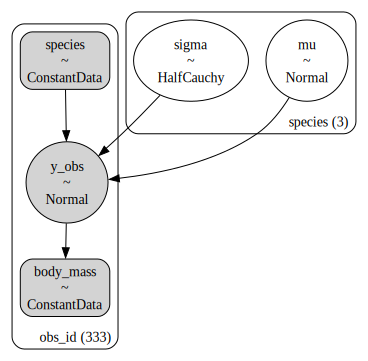

In [21]:
pm.model_to_graphviz(labeled_model)

Eseguiamo il campionamento.

In [22]:
with labeled_model:
    labeled_idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:02.032599
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:03<?, ?it/s]



Running chain 0:   5%|▌         | 100/2000 [00:03<00:06, 280.50it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 537.05it/s]

Sampling time =  0:00:03.897225
Transforming variables...
Transformation time =  0:00:00.022990


Esaminiamo le distribuzioni a posteriori e le diagnostiche del campionamento.

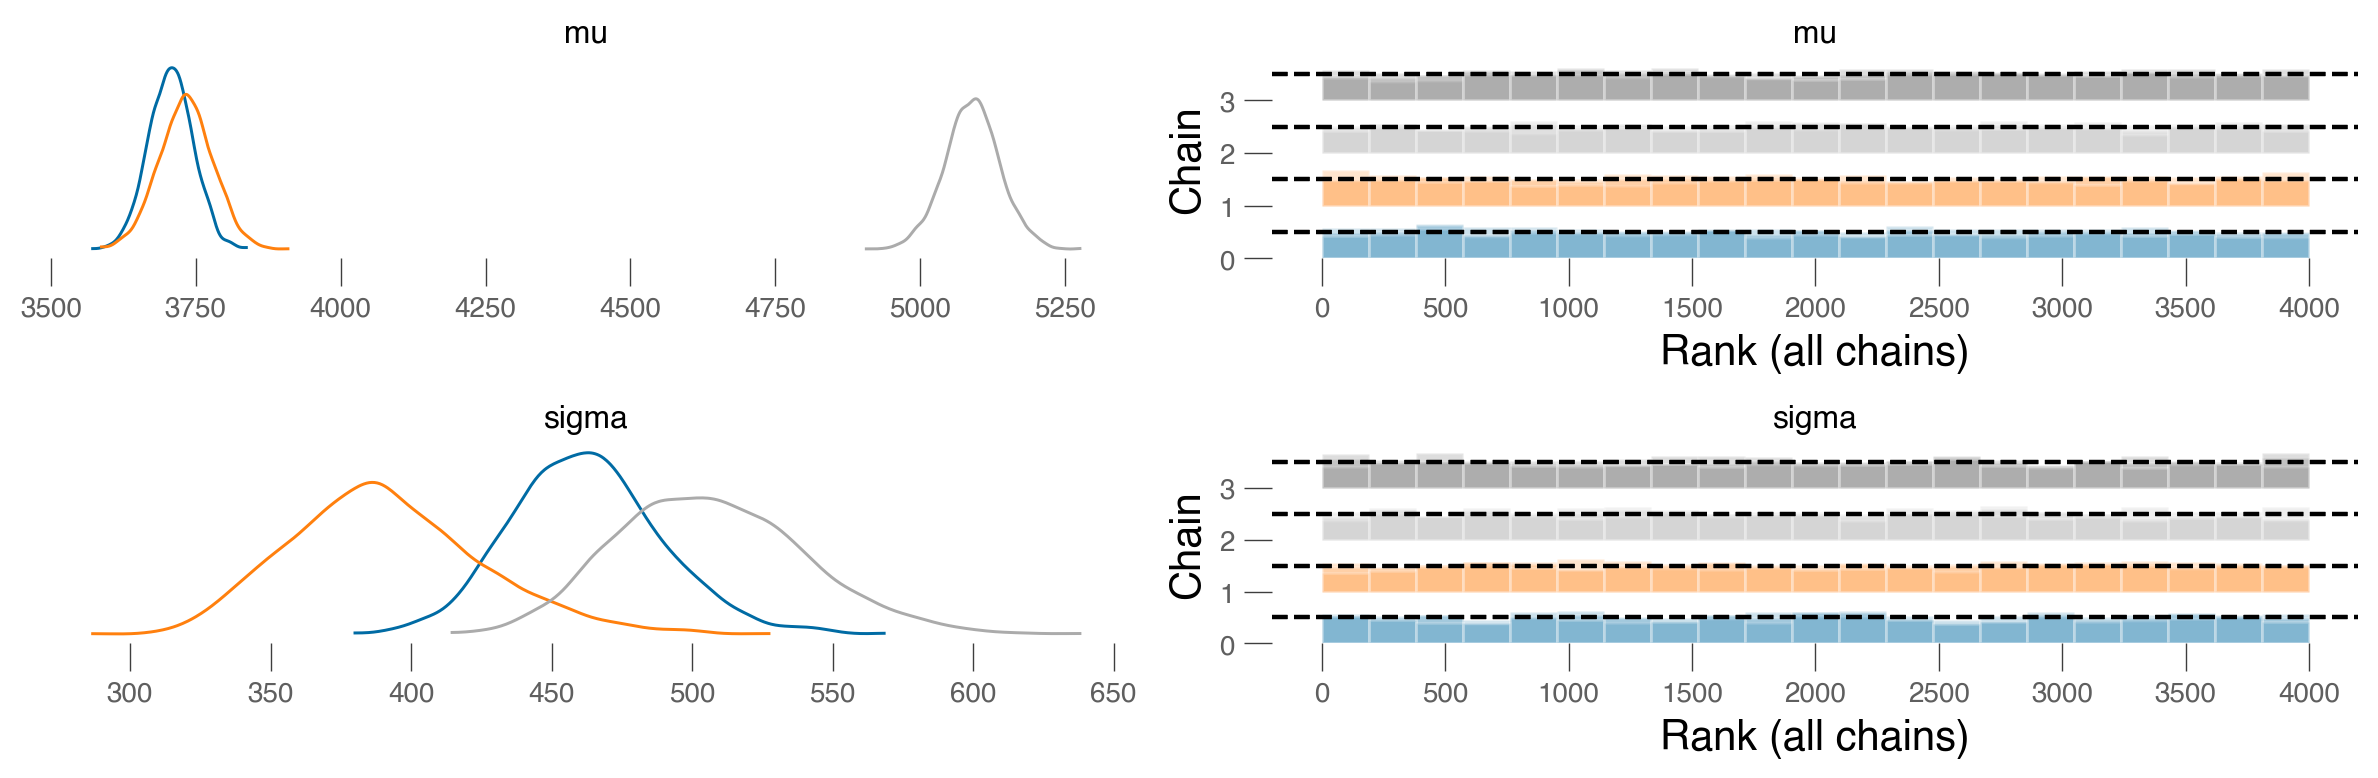

In [23]:
axes = az.plot_trace(
    labeled_idata, combined=True, kind="rank_bars"
)
plt.tight_layout()
plt.show()

Abbiamo ottenuto tre distribuzioni a posteriori per ciascuno dei due parametri $\mu$ e $\sigma$, una distribuzione per ciascuna specie di pinguini.

Esaminiamo se le quattro catene hanno prodotto risultati diversi per il parametro $\mu$.

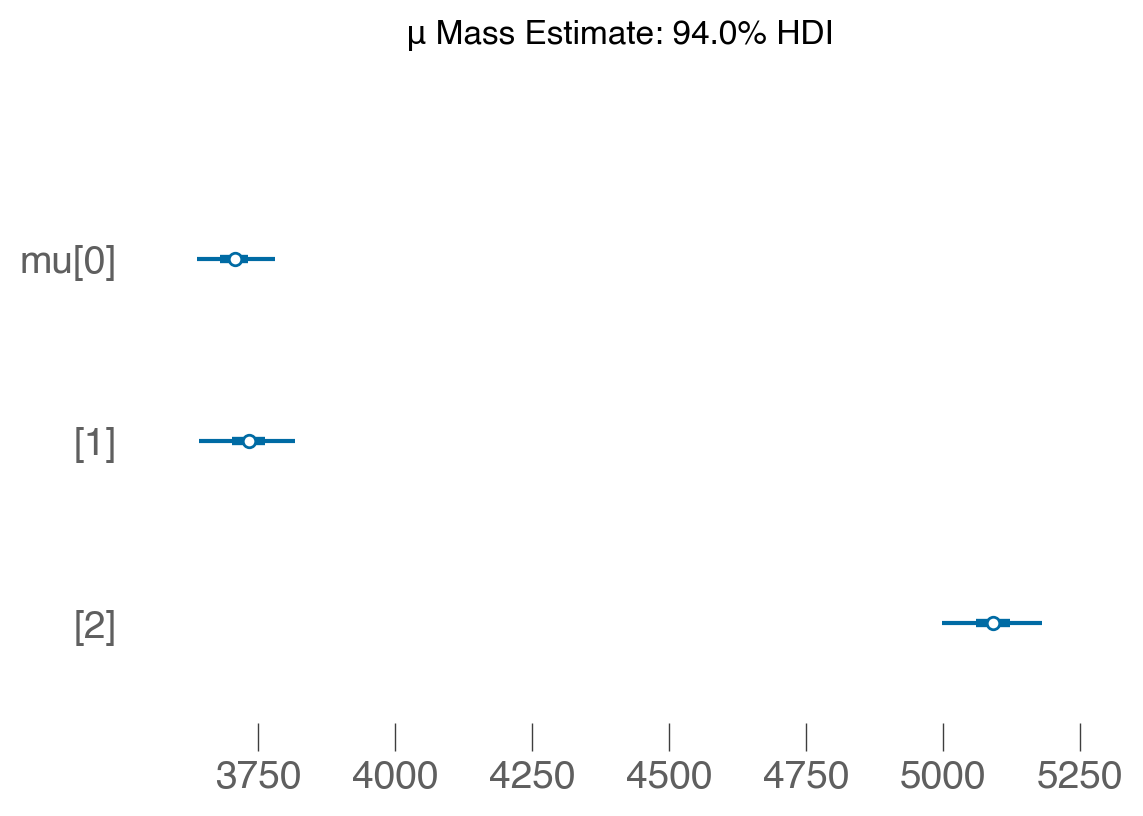

In [24]:
axes = az.plot_forest(labeled_idata, combined=True, var_names=["mu"])
axes[0].set_title("μ Mass Estimate: 94.0% HDI")
plt.show()

Facciamo la stessa cosa per il parametro $\sigma$.

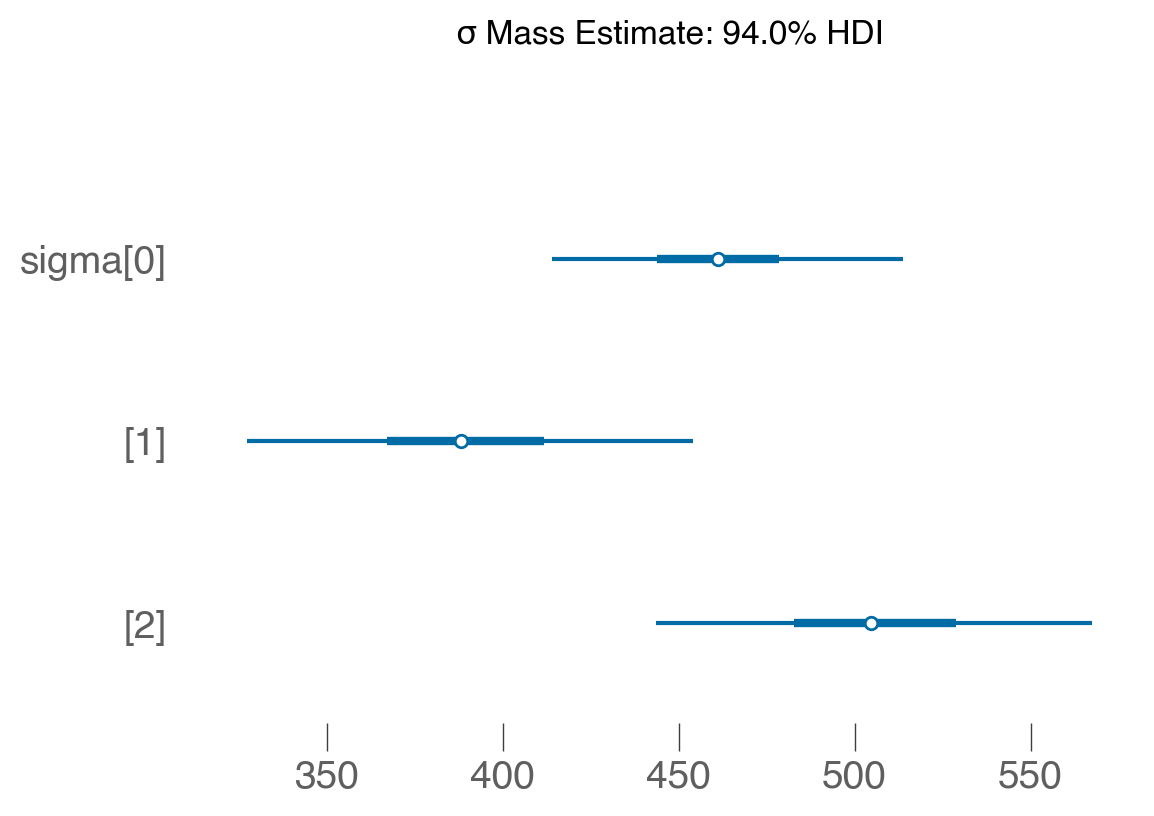

In [25]:
axes = az.plot_forest(labeled_idata, var_names=["sigma"], combined=True)
axes[0].set_title("σ Mass Estimate: 94.0% HDI")
plt.show()

Un sommario numerico delle distribuzioni a posteriori si ottiene nel modo seguente.

In [33]:
az.summary(labeled_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],3706.718,39.193,3632.615,3780.648,0.511,0.362,5916.0,2530.0,1.0
mu[1],3733.316,47.318,3645.162,3821.646,0.629,0.445,5643.0,3107.0,1.0
mu[2],5089.907,45.002,5004.403,5175.661,0.609,0.431,5467.0,3083.0,1.0
sigma[0],462.343,26.912,413.379,514.329,0.352,0.252,6048.0,2837.0,1.0
sigma[1],390.647,34.509,331.072,461.177,0.516,0.374,4718.0,2889.0,1.0
sigma[2],506.585,34.442,444.245,572.890,0.473,0.339,5478.0,2949.0,1.0


Dalle distribuzioni a posteriori e dagli intervalli di credibilità, possiamo dedurre che il peso dei pinguini Adelie e Chinstrap è simile, mentre i pinguini Gentoo sono in genere più pesanti. Inoltre, l'analisi indica che il peso dei pinguini Gentoo ha una maggiore variabilità rispetto ai pinguini Adelie, seguita da quella dei pinguini Chinstrap. Al contrario, i pinguini Chinstrap mostrano una maggiore omogeneità nel peso.

## Verifica di ipotesi bayesiana

Una volta ottenuto un campione della distribuzione a priori del parametro di interesse $\mu$ per ciascuna delle tre specie di pinguini, possiamo chiederci quale sia la probabilità che il peso di un pinguino di una specie sia maggiore di quello di un pinguino di un'altra specie. Possiamo rispondere a questa domanda utilizzando un campione casuale della distribuzione a posteriori. Per fare ciò, dobbiamo confrontare il parametro di interesse per molti valori e calcolare la media dei valori trovati.

Per recuperare i valori numerici della distribuzione a posteriori del parametro $\mu$ dall'oggetto `labeled_idata`, possiamo utilizzare le funzioni di `ArviZ`. Esaminiamo le proprietà dell'oggetto `labeled_idata`.

In [34]:
labeled_idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Recuperiamo i valori a posteriori del parametro $\mu$.

In [35]:
mu_post = labeled_idata.posterior['mu']

L'oggett ottenuto è un array di dimensioni $4 \times 1000 \times 3$. L'indice 4 si riferisce alle catente, l'indice 1000 si riferisce al numero di campioni ottenuti, l'indice 3 si riferisce ai gruppi. 

In [36]:
mu_post.shape

(4, 1000, 3)

Per trovare la media a posteriori del parametro $\mu$ della specie Adelie prendiamo le osservazioni che si riferiscono a tutte le catene (:), a tutti i valori campionati (:) per il primo gruppo (0). La media a posteriori dei pinguini Adelie è dunque uguale a

In [37]:
print(mu_post[:, :, 0].mean())

<xarray.DataArray 'mu' ()>
array(3706.71849612)
Coordinates:
    species  int64 0


Per tutte e tre le specie (Adelie, Gentoo, Chinstrap) abbiamo

In [38]:
np.array(
    [mu_post[:, :, 0].mean(), mu_post[:, :, 1].mean(), mu_post[:, :, 2].mean()]
).round(1)

array([3706.7, 3733.3, 5089.9])

Confrontiamo questi risultati con le statistiche descrittive del campione.

In [39]:
summary_stats = (
    penguins.loc[:, ["species", "body_mass_g"]]
    .groupby("species")
    .aggregate(["mean", "std", "count"])
)
summary_stats.round(1)

body_mass_g             
                 mean    std count
species                           
Adelie         3706.2  458.6   146
Chinstrap      3733.1  384.3    68
Gentoo         5092.4  501.5   119

Per verificare che l'ordinamento dei gruppi corrisponda a Adelie, Gentoo, Chinstrap, esaminiamo la stima a posteriori della deviazione standard delle tre specie. 

In [40]:
sigma_post = labeled_idata.posterior["sigma"]
np.array(
    [sigma_post[:, :, 0].mean(), sigma_post[:, :, 1].mean(), sigma_post[:, :, 2].mean()]
).round(1)

array([462.3, 390.6, 506.6])

I valori trovati confermano quello che ci aspettavamo. Ora che abbiamo capito come estrarre le stime a posteriori di un parametro per ciascun gruppo, possiamo passare al test di ipotesi bayesiano.
Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Chinstrap.

In [41]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 1]])

0.6725

Chiediamoci quale sia la probabilità che un pinguino Adelie abbia un peso minore di un pinguino Gentoo.

In [42]:
np.mean([mu_post[:, :, 0] < mu_post[:, :, 2]])

1.0

Chiediamoci quale sia la probabilità che un pinguino Chinstrap abbia un peso minore di un pinguino Gentoo.

In [43]:
np.mean([mu_post[:, :, 1] < mu_post[:, :, 2]])

1.0

Consideriamo ora le deviazioni standard. Troviamo la probabilità che la varianza del peso dei pinguini Adelie sia minore di quella dei pinguini Chinstrap.

In [44]:
np.mean([sigma_post[:, :, 0] < sigma_post[:, :, 1]])

0.0535

## Commenti e considerazioni finali 

Nel presente capitolo, abbiamo esplorato due metodologie per l'inferenza parametrica relativa a distribuzioni normali in contesti di gruppi di dati osservati indipendenti. In seguito, ci concentreremo su un diverso approccio analitico, particolarmente rilevante quando si ritiene che i gruppi studiati costituiscano specifiche manifestazioni di una categoria più generale e sottostante. Questo metodo alternativo, largamente utilizzato nel campo della psicologia, è rappresentato dai modelli gerarchici bayesiani.

## Watermark

In [45]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Thu Aug 31 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

pytensor: 2.14.2

pymc      : 5.7.2
numpy     : 1.25.2
scipy     : 1.11.2
xarray    : 2023.8.0
matplotlib: 3.7.2
pandas    : 2.0.3
arviz     : 0.16.1
seaborn   : 0.12.2

Watermark: 2.4.3

